In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
df= pd.read_csv("result.csv")
df.columns= ["Product", "Price", "Location", "Spec"]
df.head()

,Product,Price,Location,Spec
0,Dijual Apartemen Springhill Terrace Kemayoran,Rp 2.000.000.000,"Kemayoran, Jakarta Pusat",3 KT - 2 KM - 99 m2
1,Apartment The Newton 1 Kuningan Setiabudi Cipu...,Rp 1.600.000.000,"Setia Budi, Jakarta Selatan",1 KT - 1 KM - 25 m2
2,Rumah Mewah Modren Harga Murah di Taman Sari J...,Rp 528.000.000,"Taman Sari, Jakarta Barat",2 KT - 2 KM - 42 m2
3,Rumah Asri di Marunda Baru Jakarta Utara,Rp 1.030.000.000,"Tanjung Priok, Jakarta Utara",3 KT - 2 KM - 65 m2
4,Disewakan Apartemen Murah Cuma 2 Jutaan Tower ...,Rp 2.000.000,"Kelapa Gading, Jakarta Utara",1 KT - 1 KM - 21 m2


In [4]:
# clean price

df["Price"]= df["Price"].str.replace('(\D)', "", regex= True)
df["Price"]= df["Price"].str.strip()
df["Price"]= df["Price"].astype("int64")
df.head()

,Product,Price,Location,Spec
0,Dijual Apartemen Springhill Terrace Kemayoran,2000000000,"Kemayoran, Jakarta Pusat",3 KT - 2 KM - 99 m2
1,Apartment The Newton 1 Kuningan Setiabudi Cipu...,1600000000,"Setia Budi, Jakarta Selatan",1 KT - 1 KM - 25 m2
2,Rumah Mewah Modren Harga Murah di Taman Sari J...,528000000,"Taman Sari, Jakarta Barat",2 KT - 2 KM - 42 m2
3,Rumah Asri di Marunda Baru Jakarta Utara,1030000000,"Tanjung Priok, Jakarta Utara",3 KT - 2 KM - 65 m2
4,Disewakan Apartemen Murah Cuma 2 Jutaan Tower ...,2000000,"Kelapa Gading, Jakarta Utara",1 KT - 1 KM - 21 m2


In [5]:
# clean location

df["Location"]= df["Location"].str.split(", ").str[-1]
df["Location"]= df["Location"].str.replace("Kota", "")
df["Location"]= df["Location"].str.replace("Kab.", "")
df["Location"]= df["Location"].str.strip()

df.loc[(df["Location"].str.contains("Jakarta")), "Location"] = "Jakarta"

In [6]:
# clean house for rent and ruko

index_to_drop= df[df["Product"].str.contains(r"[Ss]ewa", regex= True)].index.tolist()
index_to_drop= index_to_drop + (df[df["Product"].str.contains(r"[Kk]ontrak", regex= True)].index.tolist())
index_to_drop= index_to_drop + (df[df["Product"].str.contains(r"[Kk]os", regex= True)].index.tolist())
index_to_drop= index_to_drop + (df[df["Product"].str.contains(r"[Rr]uko", regex= True)].index.tolist())
index_to_drop= list(set(index_to_drop))

df= df.drop(index= index_to_drop)

In [7]:
# clean price > 50 million (improbable or probably for rent)

index_to_drop= df[df["Price"] < 50000000].index.tolist()
df= df.drop(index= index_to_drop)

In [8]:
# remove q95 upwards (too big)

len_df_before= len(df)
print(f'Length df before= {len_df_before}')

# from scipy import stats
# list_loc= df["Location"].unique().tolist()
# for city in list_loc:
#     mask_zscore= stats.zscore(df.loc[(df["Location"] == city), "Price"]) > 3
#     list_outlier= df.loc[(df["Location"] == city)][mask_zscore].index.tolist()
#     df= df.drop(index= list_outlier)

list_loc= df["Location"].unique().tolist()
for city in list_loc:
    q_95= df.loc[(df["Location"] == city), "Price"].quantile(0.95)
    mask_q95= df.loc[(df["Location"] == city), "Price"] > q_95
    list_outlier= df[df["Location"] == city][mask_q95].index.tolist()
    df= df.drop(index= list_outlier)

len_df_after= len(df)
print(f'Length df after= {len_df_after}')
print(f'Dropped rows= {len_df_before-len_df_after}')

Length df before= 23947
Length df after= 22799
Dropped rows= 1148


In [9]:
# remove duplicate

df= df.drop_duplicates()

# Visualization

In [10]:
list_city= ['Semarang','Surabaya',
       'Bandung', 'Tangerang', 'Bekasi', 'Jakarta',
       'Temanggung', 'Yogyakarta']

data= df[
    df["Location"].isin(list_city)
]

list_sort= data.groupby("Location")["Price"].median().sort_values(ascending= False).index.to_list()
list_title= [
    'Kota Surabaya',
    'Kota Yogyakarta',
    'Prov. Jakarta',
    'Kota Bandung',
    'Kota Tangerang',
    'Kota Semarang',
    'Kota Bekasi',
    'Kab. Temanggung'
    ]

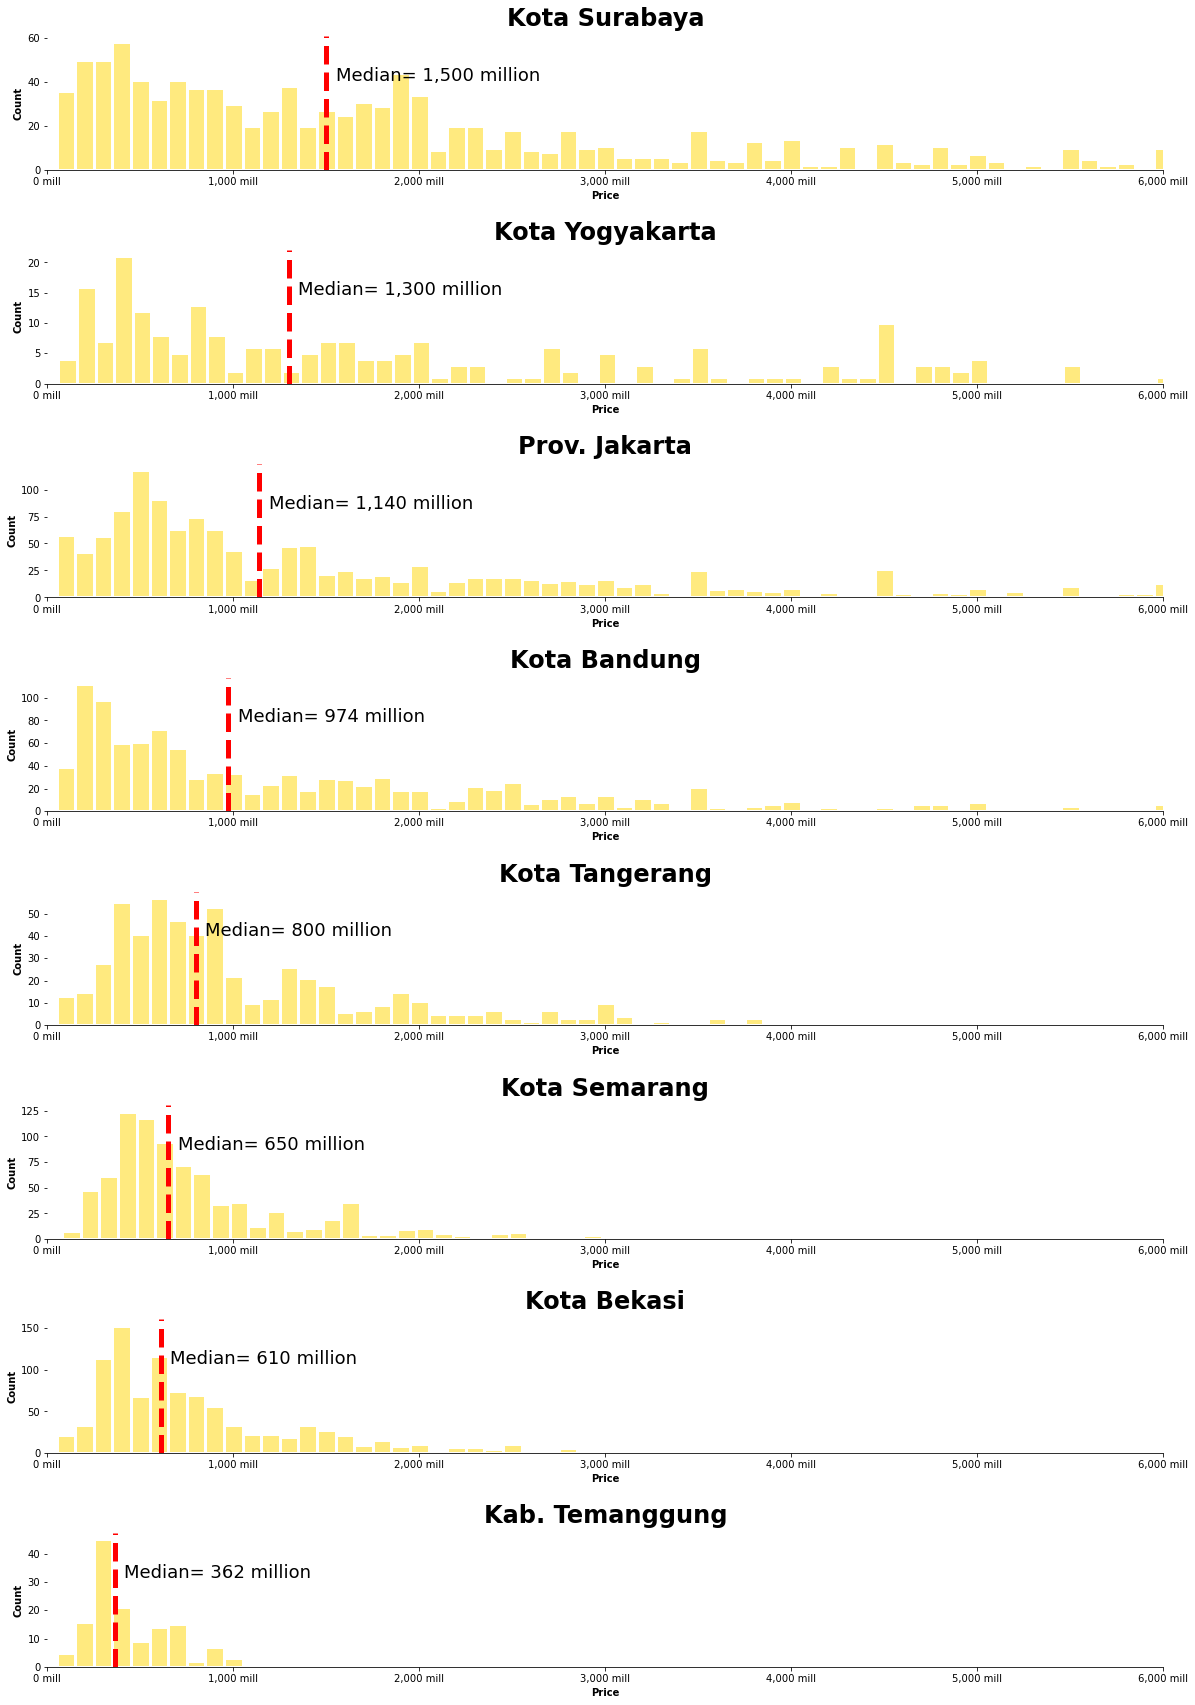

In [18]:
fig, axs = plt.subplots(nrows= 8, figsize=(20, 30))

i = 0

for city in list_sort:

    median=  data.loc[(data["Location"] == city), "Price"].median()

    sns.histplot(
        data= data[data["Location"] == city],
        x= "Price",
        binwidth= 100000000,
        color= "#FFD700",
        alpha= 0.5,
        edgecolor= "white", 
        ax= axs[i]
    )

    axs[i].axvline(x= median,
        color= 'red',
        lw= 5,
        ls= "--")

    axs[i].text(
        x= median + 50000000, 
        y= (axs[i].get_ylim())[1] / 1.5,
        fontsize= 18,
        s= 'Median= {median:,.0f} million'.format(
            median= (median/1000000)
    ))

    plt.setp(axs[i].patches, linewidth= 3)
    axs[i].set_xlim([0, (data["Price"].max())/2])
    xlabels = ['{:,.0f}'.format(x) + ' mill' for x in axs[i].get_xticks()/1000000]
    axs[i].set_xticklabels(xlabels)
    axs[i].set_xlabel("Price", fontweight= "bold")
    axs[i].set_ylabel("Count", fontweight= "bold")
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].set_title(list_title[i], pad= 10, fontdict= 
        {
            'fontsize': 24,
            'fontweight': "bold",
            'verticalalignment': 'baseline',
            'horizontalalignment': "center"
            })

    i = i + 1

plt.subplots_adjust(hspace= 0.6)
# plt.savefig("graph_1.png", facecolor= "white", bbox_inches= "tight")
plt.show()

In [12]:
# sort data by median per city

list_city= data.groupby("Location")["Price"].median().sort_values(ascending= False).index.tolist()
list_number= list(range(1, len(list_city) + 1))

res = {}
for key in list_city:
    for value in list_number:
        res[key] = value
        list_number.remove(value)
        break  

data["Order"]= data["Location"].map(res)
data= data.sort_values("Order")

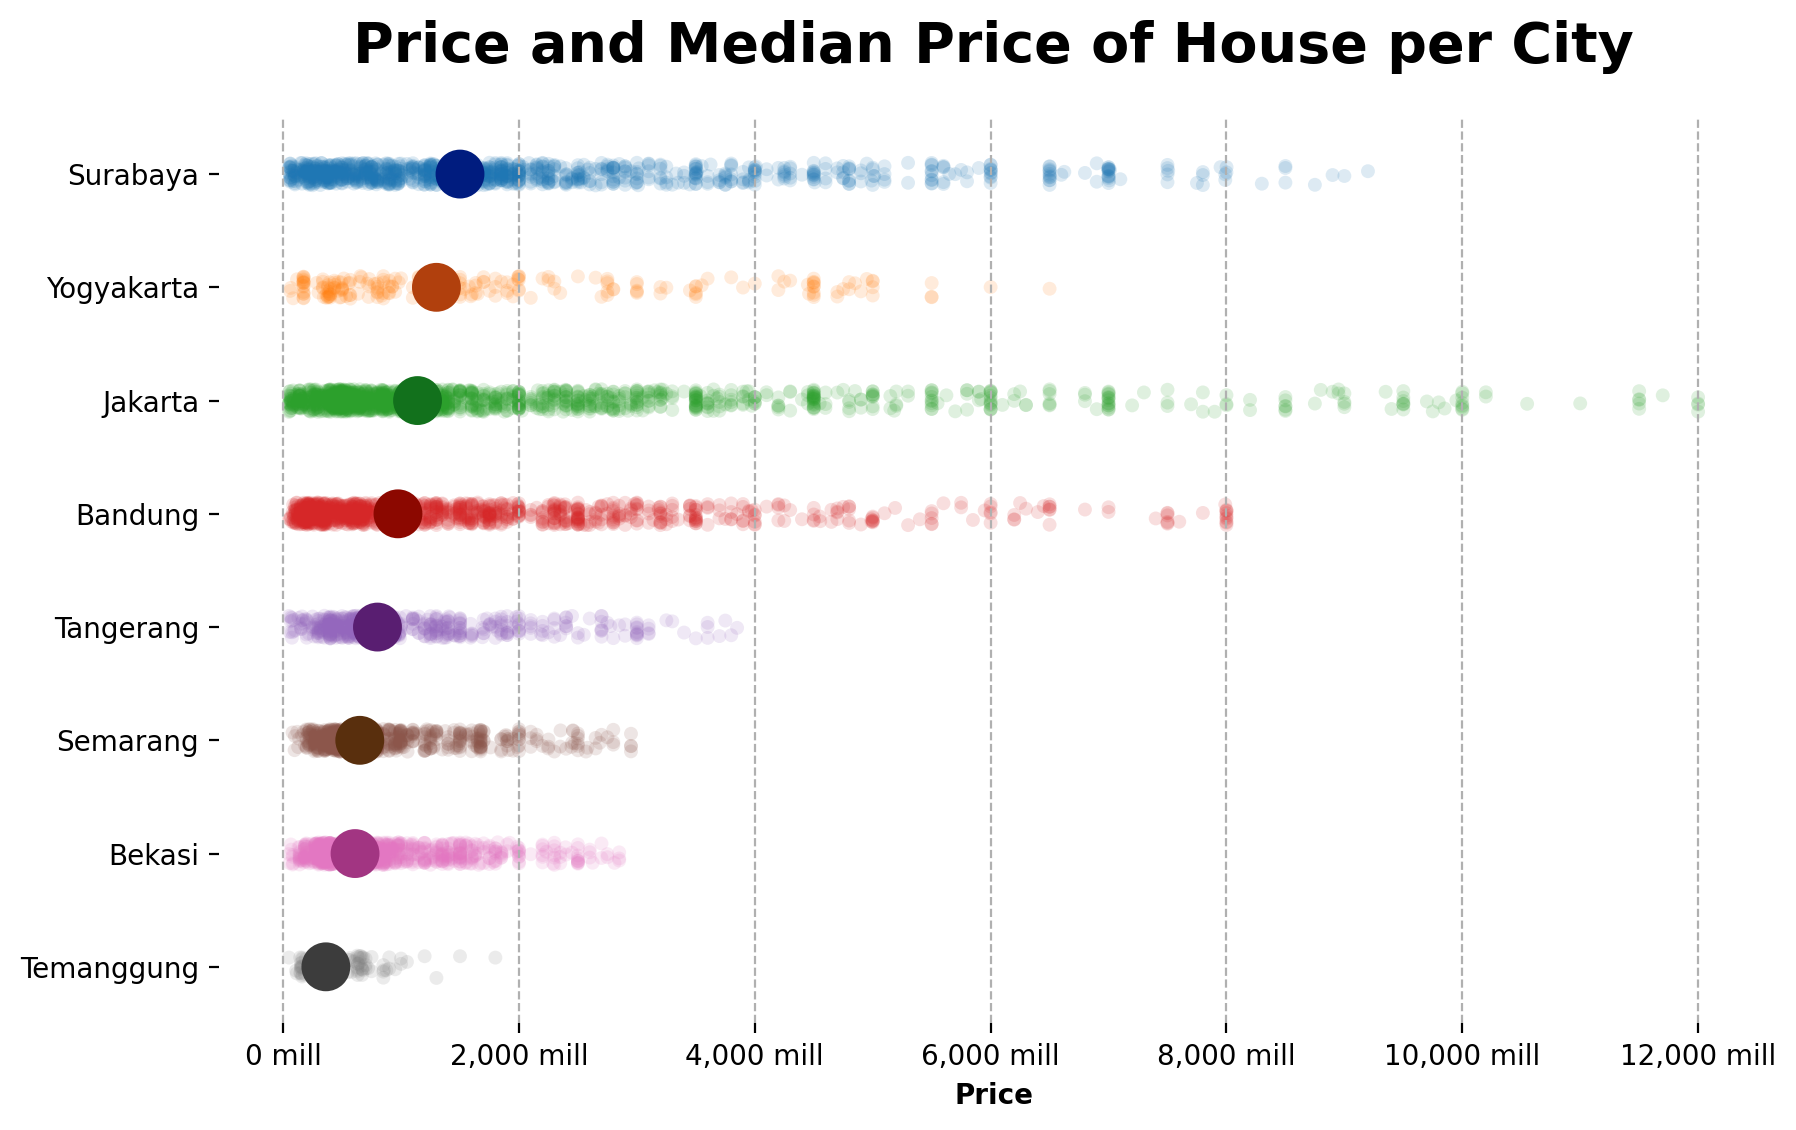

In [17]:
plt.figure(figsize= (10, 6), dpi= 200)

ax= sns.stripplot(data= data, x= "Price", y= "Location", alpha= 0.15, zorder= 1)

ax= sns.pointplot(x="Price", y="Location", estimator= np.median, join= False, palette= "dark",
              ci= None, data=data, markers= "o", zorder= 5, scale= 2)

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlabel("Price", fontweight= "bold")
ax.set_ylabel("")
ax.set_title("Price and Median Price of House per City", fontsize= 20, fontweight= "bold", pad= 20)

xlabels = ['{:,.0f}'.format(x) + ' mill' for x in ax.get_xticks()/1000000]
ax.set_xticklabels(xlabels)

plt.grid(axis= "x", linestyle= "--")

# plt.savefig("graph_2.png", facecolor= "white", bbox_inches= "tight")
plt.show()